In [ ]:
DATASET_NAME = "Milano_sample"   # default demo

from pathlib import Path
import sys

PROJECT_ROOT = Path("..").resolve()

DATA_ROOT = PROJECT_ROOT / "test" / "data"
RASTER_DIR = DATA_ROOT / "raw" / "Raster" / DATASET_NAME

OUT_DIR = PROJECT_ROOT / "test" / "outputs" / f"notebook_{DATASET_NAME}"
OUT_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

if not RASTER_DIR.exists():
    raise FileNotFoundError(
        f"Dataset directory not found: {RASTER_DIR}\n"
        "Make sure the dataset is placed under test/data/raw/Raster/."
    )

print("Project root :", PROJECT_ROOT)
print("Dataset name :", DATASET_NAME)
print("Raster dir   :", RASTER_DIR)
print("Output dir   :", OUT_DIR)


Project root : /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean
Dataset name : Milano_sample
Raster dir   : /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/data/raw/Raster/Milano_sample
Output dir   : /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/outputs/notebook_Milano_sample


# GeoSimpleClassify: Step-by-Step Workflow

This notebook demonstrates the detailed workflow of the GeoSimpleClassify project. 

We will break down the automated pipelines into individual steps to better understand how satellite imagery is processed and classified.


## 1. Environment Setup

We begin by importing the required external libraries and the internal modules of the
GeoSimpleClassify project.


In [52]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
from geosimpleclassify.config.schema import default_cfg

# Core Processing Functions
from geosimpleclassify.core.mosaic import merge_rasters
from geosimpleclassify.core.clip import clip_raster_with_vector
from geosimpleclassify.core.preprocess import (
    stack_bands,
    to_float32,
    clip_by_percentile,
    normalize,
    make_valid_mask
)
from geosimpleclassify.core.geo_io import save_raster, load_raster, load_mask_aligned
from geosimpleclassify.core.feature import extract_pixel_features
from geosimpleclassify.core.unsupervised import unsupervised_cluster
from geosimpleclassify.core.supervised import supervised_classify
from geosimpleclassify.core.postprocess import (
    reshape_labels_to_raster, 
    visualize, 
    compare_and_save, 
    save_label_summary,   # Add this
    plot_label_histogram  # Add this
)
# Pipeline Helpers
from geosimpleclassify.pipelines.run_preprocess import find_band_tif
from geosimpleclassify.pipelines.run_classify import find_cube_and_mask, get_classify_output_subdir

print("Environment ready and project modules imported.")

Environment ready and project modules imported.


## 2. Global Configuration

In this step, we initialize the global project configuration and define all
input and output paths used throughout the workflow.


In [54]:
from geosimpleclassify.config.schema import default_cfg

# 1. Initialize configuration
cfg = default_cfg()

# Define path config
cfg.paths.project_root = PROJECT_ROOT
cfg.paths.data_dir = PROJECT_ROOT / "test" / "data"

# Input paths
cfg.paths.preprocess_input_raster_dir = RASTER_DIR
cfg.paths.preprocess_input_vector_path = cfg.paths.data_dir / "raw" / "Vector" / "ProvCM01012025_WGS84.shp"

# Output paths 
cfg.paths.preprocess_derived_dir = OUT_DIR / "derived"
cfg.paths.preprocess_derived_dir.mkdir(parents=True, exist_ok=True)
cfg.paths.preprocess_final_dir = OUT_DIR / "final" / "preprocess"
cfg.paths.preprocess_final_dir.mkdir(parents=True, exist_ok=True)

# Classify paths
cfg.paths.classify_input_dir = cfg.paths.preprocess_final_dir
cfg.paths.classify_final_dir = OUT_DIR / "final" / "classify"
cfg.paths.classify_final_dir.mkdir(parents=True, exist_ok=True)


# 2. Preprocess Parameters
cfg.preprocess.band_codes = ["B02", "B03", "B04", "B08"]
cfg.preprocess.clip_attr_name = "DEN_CM"    # Vector attribute for clipping
cfg.preprocess.clip_attr_value = "Milano"    # Attribute value for clipping
cfg.preprocess.nodata_value = 0


# 3. Classify Parameters
cfg.classify.band_codes = ["B02", "B03", "B04", "B08"]   
cfg.classify.random_state = 42                           
cfg.classify.visualize_show = True    # Display plots in notebook
cfg.classify.export_labels_rgb = True                    

# ROI Settings
# Set use_roi=True if you want to classify only a specific part of the image
# In this sample data, we classify the full image
cfg.classify.use_roi = False 
cfg.classify.roi_window = (2000, 3024, 2000, 3024)       

# Unsupervised classify parameters
# We use KMeans clustering and set number of clusters to 8
cfg.classify.unsup_method = "kmeans" 
cfg.classify.n_clusters = 8   

# FAST MODE (MiniBatchKMeans)
# Highly recommended for large satellite images to reduce processing time
cfg.classify.fast_mode = True
cfg.classify.unsup_sample_size = 200000     # Number of samples for MiniBatchKMeans fitting
cfg.classify.unsup_batch_size = 4096    # Batch size for MiniBatchKMeans
cfg.classify.unsup_max_iter = 100    # Maximum training iterations
cfg.classify.unsup_predict_chunk = 500000    # Chunk size for prediction          

# Supervised Refinement Parameters
# We use Random Forest for refinement
cfg.classify.sup_model = "rf"    # Refinement model: "rf" or "svm"

# Output Coding
cfg.classify.nodata_label = 0    # Label for background
cfg.classify.label_offset = 1    # Start class labels from 1

print("Full configuration initialized. ")

Full configuration initialized. 


## 3. Preprocessing: Mosaic and Clip

The area we want to analyze may be covered by multiple image tiles rather
than a single raster.

In this step, we combine the tiles corresponding to each spectral band into
one continuous mosaic by ensuring consistent projection and resolution and then 
clip the result to the area of interest defined by a vector boundary.

--- Processing Band: B02 ---
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/outputs/notebook_Milano_sample/derived/B02_clip.tif


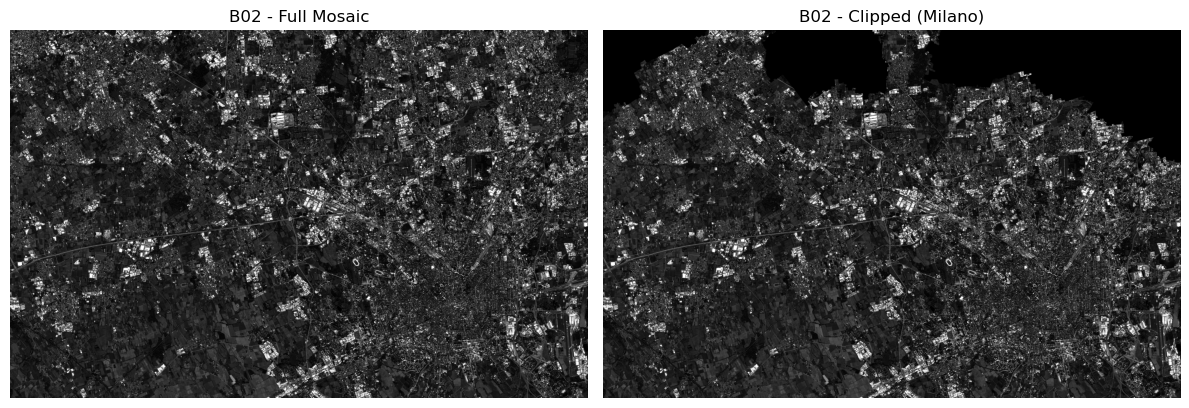

--- Processing Band: B03 ---
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/outputs/notebook_Milano_sample/derived/B03_clip.tif


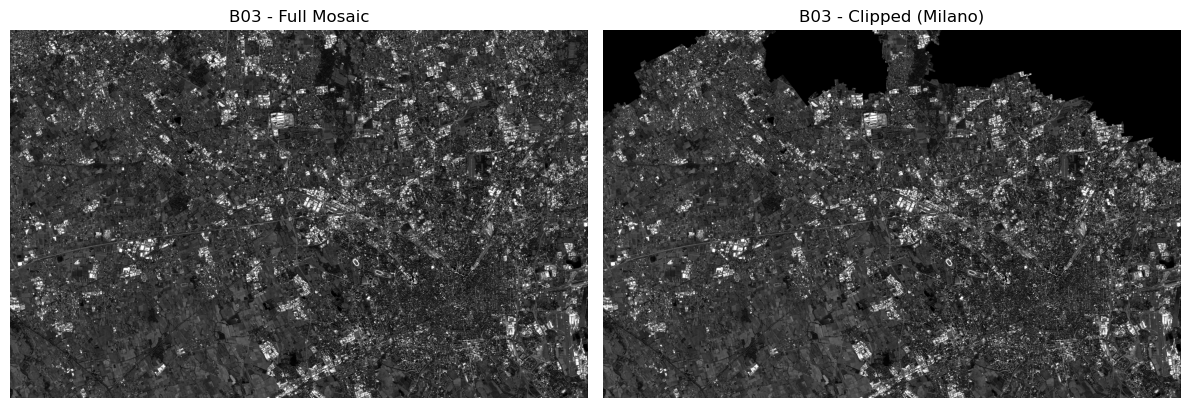

--- Processing Band: B04 ---
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/outputs/notebook_Milano_sample/derived/B04_clip.tif


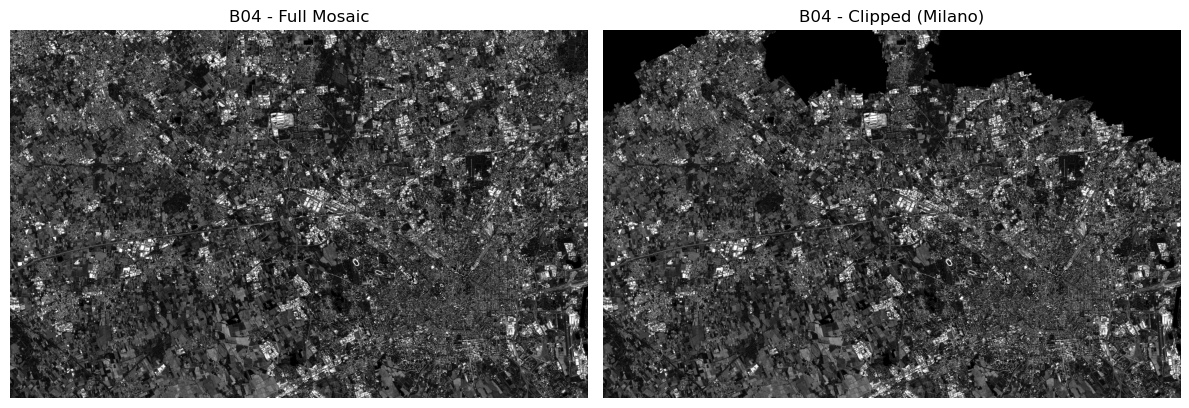

--- Processing Band: B08 ---
Clipped raster saved to /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/outputs/notebook_Milano_sample/derived/B08_clip.tif


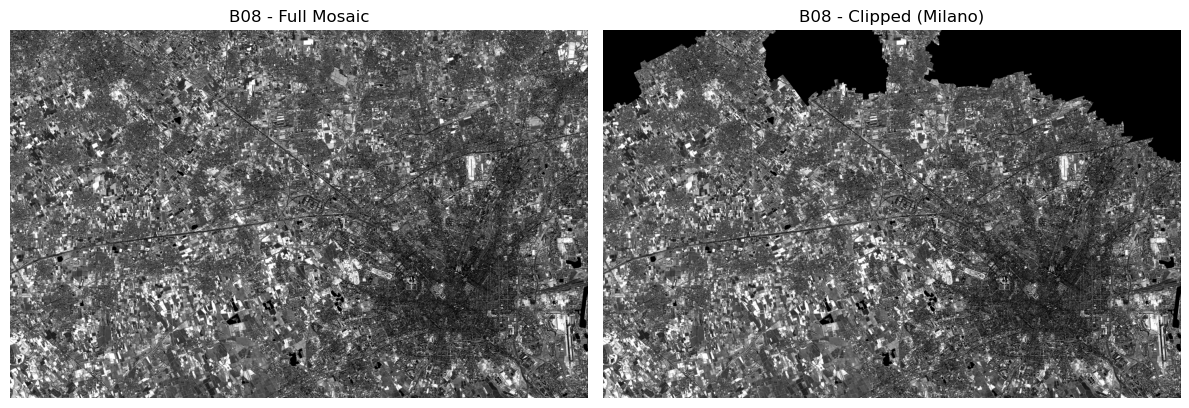

Mosaic and clipping complete.


In [55]:
import matplotlib.pyplot as plt

clipped_bands = []
meta_ref = None

# Helper function for visualization stretching
def stretch_image(arr, low=2, high=98):
    """Simple percentile stretch for better visualization of raw data."""
    v_min, v_max = np.percentile(arr[arr > 0], [low, high]) # Ignore 0 (nodata) for stats
    stretched = np.clip((arr - v_min) / (v_max - v_min), 0, 1)
    return stretched

for band_code in cfg.preprocess.band_codes:
    print(f"--- Processing Band: {band_code} ---")
    
    # 1. Locate band tiles
    tile_dirs = sorted([p for p in cfg.paths.preprocess_input_raster_dir.iterdir() if p.is_dir()])
    raster_paths = [find_band_tif(td, band_code) for td in tile_dirs]
    
    # 2. Merge tiles into a Mosaic
    mosaic_out = cfg.paths.preprocess_derived_dir / f"{band_code}_mosaic.tif"
    meta_mosaic, arr_mosaic = merge_rasters(
        [str(p) for p in raster_paths], out_path=str(mosaic_out)
    )
    
    # 3. Clip mosaic with Vector boundary
    clip_out = cfg.paths.preprocess_derived_dir / f"{band_code}_clip.tif"
    meta_clip, arr_clip = clip_raster_with_vector(
        raster_path=str(mosaic_out),
        vector_path=str(cfg.paths.preprocess_input_vector_path),
        out_path=str(clip_out),
        attr_name=cfg.preprocess.clip_attr_name,
        attr_value=cfg.preprocess.clip_attr_value,
    )
    
    # --- STEP 4: VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Mosaic Preview (Full Extent)
    axes[0].imshow(stretch_image(arr_mosaic.squeeze()), cmap='gray')
    axes[0].set_title(f"{band_code} - Full Mosaic")
    axes[0].axis('off')
    
    # Clipped Preview (Milano Area)
    axes[1].imshow(stretch_image(arr_clip.squeeze()), cmap='gray')
    axes[1].set_title(f"{band_code} - Clipped (Milano)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Keep reference metadata and store the clipped array
    if meta_ref is None:
        meta_ref = meta_clip
    clipped_bands.append(arr_clip.squeeze())

print("Mosaic and clipping complete.")

## 4. Normalization and Data Cube Construction

After preprocessing, we stack the individual spectral bands into a single
multi-band data cube.

The pixel values are rescaled to a common range, and a mask is created to
select only the pixels that will be used in the following analysis steps.


In [56]:
# 1. Stack and Preprocess
cube = stack_bands(clipped_bands)
cube = to_float32(cube)
cube = clip_by_percentile(cube, low=1.0, high=99.0)
cube_norm = normalize(cube)
mask = make_valid_mask(cube, nodata_value=cfg.preprocess.nodata_value)

# Print global min and max (excluding potential NaN or invalid values)
print(f"Cube Norm - Global Min: {np.nanmin(cube_norm):.4f}, Global Max: {np.nanmax(cube_norm):.4f}")

# Print min and max per band to ensure each channel is correctly normalized
for i, band in enumerate(cfg.preprocess.band_codes):
    b_min = np.nanmin(cube_norm[i])
    b_max = np.nanmax(cube_norm[i])
    print(f"  Band {band} - Min: {b_min:.4f}, Max: {b_max:.4f}")
    
# 2. Save final preprocessed files
bands_tag = "_".join(cfg.preprocess.band_codes)
save_raster(str(cfg.paths.preprocess_final_dir / f"{bands_tag}_norm.tif"), meta_ref, cube_norm, dtype="float32")
save_raster(str(cfg.paths.preprocess_final_dir / f"{bands_tag}_mask.tif"), meta_ref, mask.astype("uint8"), dtype="uint8")

print(f"Data cube created. Shape: {cube_norm.shape}")

Cube Norm - Global Min: 0.0000, Global Max: 1.0000
  Band B02 - Min: 0.0000, Max: 1.0000
  Band B03 - Min: 0.0000, Max: 1.0000
  Band B04 - Min: 0.0000, Max: 1.0000
  Band B08 - Min: 0.0000, Max: 1.0000
Data cube created. Shape: (4, 2235, 3506)


## 5. Feature Extraction for Classification

We flatten the multi-band raster into a table of per-pixel feature vectors and keep only valid pixels, so that each pixel can be treated as a sample by the classification algorithms.


In [57]:
# Load the preprocessed normalized cube and mask
cube_path, mask_path = find_cube_and_mask(
    cfg.paths.classify_input_dir, cfg.preprocess.band_codes
)
meta_cube, cube = load_raster(str(cube_path))
mask = load_mask_aligned(str(mask_path), meta_cube)

# Flatten valid pixels into a feature matrix (N_pixels, N_bands)
features, idx, (H, W) = extract_pixel_features(cube, mask)
print(f"Features matrix shape: {features.shape}")

Features matrix shape: (6717128, 4)


## 6. Clustering and Classification Refinement

We first group pixels with similar spectral characteristics using an
unsupervised clustering step (K-Means). This provides an initial partition
of the image without requiring labeled training data.

These initial clusters are then used as guidance for a supervised
classification step based on a Random Forest model, which helps produce
cleaner and more consistent classification results.


In [58]:
# 1. Unsupervised Clustering (Initial Labels)
labels_init = unsupervised_cluster(
    features, 
    method="kmeans", 
    n_clusters=cfg.classify.n_clusters, 
    fast_mode=True, 
    random_state=42
)

# 2. Supervised Refinement (Final Labels)
labels_final = supervised_classify(
    features, 
    labels_init, 
    model="rf", 
    sample_per_class=5000, 
    random_state=42
)

print(f"Classification generated {np.unique(labels_final).size} unique classes.")

Classification generated 8 unique classes.


## 7. Data Export and Statistical Summary

Finally, we reshape the classification results back into a 2D spatial map.

In this section, the resulting maps are saved as GeoTIFF files, and a statistical summary (CSV) along with an area distribution histogram plot (PNG) are generated.


--- Land Cover Statistical Summary ---


class_id  pixel_count  percent      area_m2  area_km2
0         1      1441563  21.4610  144156300.0  144.1563
1         2       312352   4.6501   31235200.0   31.2352
2         3       465304   6.9271   46530400.0   46.5304
3         4       159016   2.3673   15901600.0   15.9016
4         5      1086677  16.1777  108667700.0  108.6677
5         6       945191  14.0714   94519100.0   94.5191
6         7      1008028  15.0068  100802800.0  100.8028
7         8      1298997  19.3386  129899700.0  129.8997


--- Area Distribution Plot ---


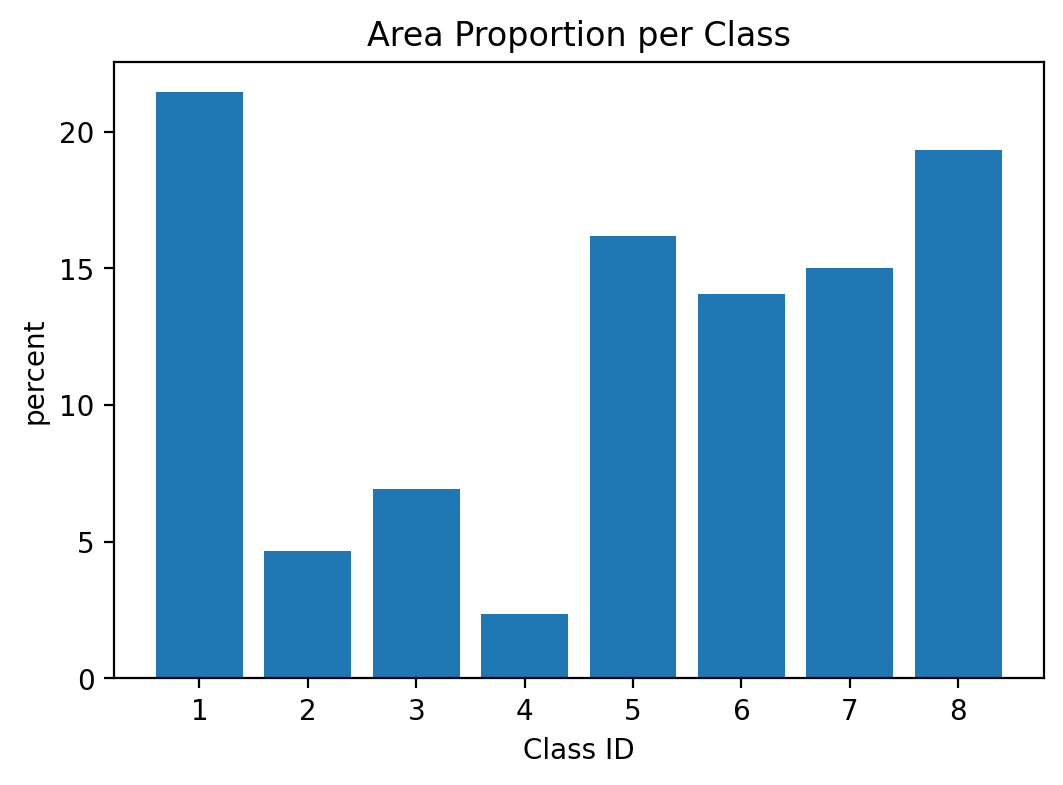

In [59]:
import pandas as pd
from IPython.display import Image, display

# 1. Reshape 1D labels back to 2D raster format using the mask
# This maps the classified pixels back to their spatial coordinates
init_map = reshape_labels_to_raster(
    labels_init, H, W, mask, 
    nodata_label=cfg.classify.nodata_label, 
    label_offset=cfg.classify.label_offset
).astype(np.uint16)

final_map = reshape_labels_to_raster(
    labels_final, H, W, mask, 
    nodata_label=cfg.classify.nodata_label, 
    label_offset=cfg.classify.label_offset
).astype(np.uint16)

# 2. Determine the correct output subdirectory
# Based on whether you used a full image or an ROI
output_dir = get_classify_output_subdir(
    cfg.paths.classify_final_dir, 
    cfg.classify.use_roi, 
    cfg.classify.roi_window
)
output_dir.mkdir(parents=True, exist_ok=True)

# 3. Save the classification maps as GeoTIFF files
bands_tag = "_".join(cfg.classify.band_codes)
init_out  = output_dir / f"{bands_tag}_labels_init.tif"
final_out = output_dir / f"{bands_tag}_labels_final.tif"

save_raster(str(init_out), meta_cube, init_map, dtype="uint16", nodata=cfg.classify.nodata_label)
save_raster(str(final_out), meta_cube, final_map, dtype="uint16", nodata=cfg.classify.nodata_label)

# 4. Generate statistical summary (CSV) and area distribution plot (PNG)
summary_csv = output_dir / "labels_final_summary.csv"
save_label_summary(
    label_map=final_map,          
    mask=mask,                    
    transform=meta_cube["transform"], # Uses affine transform to compute real-world area
    out_csv_path=str(summary_csv),
    nodata=cfg.classify.nodata_label,
)

hist_png = output_dir / "labels_final_histogram.png"
plot_label_histogram(
    summary_csv_path=str(summary_csv),
    out_png_path=str(hist_png),
    value_col="percent",          
    title="Area Proportion per Class",
)

# Display the Summary Table and Histogram
print("\n--- Land Cover Statistical Summary ---")
df_summary = pd.read_csv(summary_csv)
display(df_summary)

print("\n--- Area Distribution Plot ---")
display(Image(filename=hist_png))

## 8. Visual Comparison and Comparison Export
In this step, we generate visual previews of both the normalized RGB image
and the final land cover classification.

The two images are displayed side by side and saved to the output directory,
making it easier to visually compare the classification results with the
original input imagery.

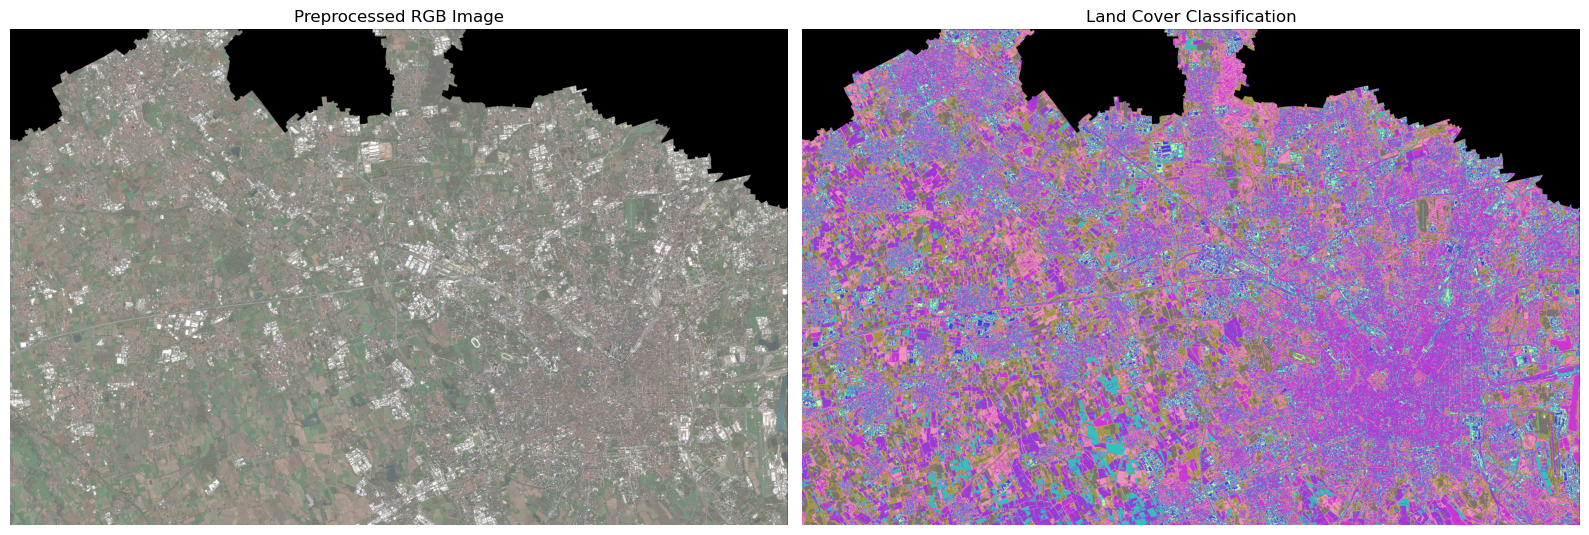

Workflow Complete. Results saved to: /Users/cachone/Desktop/Geoinformatic_Engineering/Geospatial_Processing/GeoSimpleClassify_clean/test/outputs/notebook_Milano_sample/final/classify/full


In [60]:
# 5. Generate Visualizations and Side-by-Side Comparison
rgb_preview = visualize(
    cube_norm, # Use normalized cube for visualization
    kind="cube", 
    title="Input RGB Preview", 
    show=False, 
    gamma=1.5
)

label_preview = visualize(
    final_map, 
    kind="label", 
    nodata=cfg.classify.nodata_label,
    seed=cfg.classify.random_state,
    title="Final Classified Labels", 
    show=False
)

# Save the side-by-side comparison image
compare_png = output_dir / "Input_vs_Labels_Final.png"
compare_and_save(
    left_rgb_u8=rgb_preview,
    right_rgb_u8=label_preview,
    left_title="Preprocessed RGB Image",
    right_title="Land Cover Classification",
    out_path=str(compare_png),
)

# Display the final comparison in the notebook
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(rgb_preview)
plt.title("Preprocessed RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(label_preview)
plt.title("Land Cover Classification")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Workflow Complete. Results saved to: {output_dir}")